In [2]:
# 필요한 라이브러리 임포트
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

# csv 파일 읽어서 데이터프레임 생성
df = pd.read_csv('https://raw.githubusercontent.com/selva86/datasets/master/a10.csv', parse_dates=['date'], index_col='date')

# 데이터프레임의 처음 5개 행 확인
print(df.head())

               value
date                
1991-07-01  3.526591
1991-08-01  3.180891
1991-09-01  3.252221
1991-10-01  3.611003
1991-11-01  3.565869


In [23]:
print(df.tail())

                value
date                 
2008-02-01  21.654285
2008-03-01  18.264945
2008-04-01  23.107677
2008-05-01  22.912510
2008-06-01  19.431740


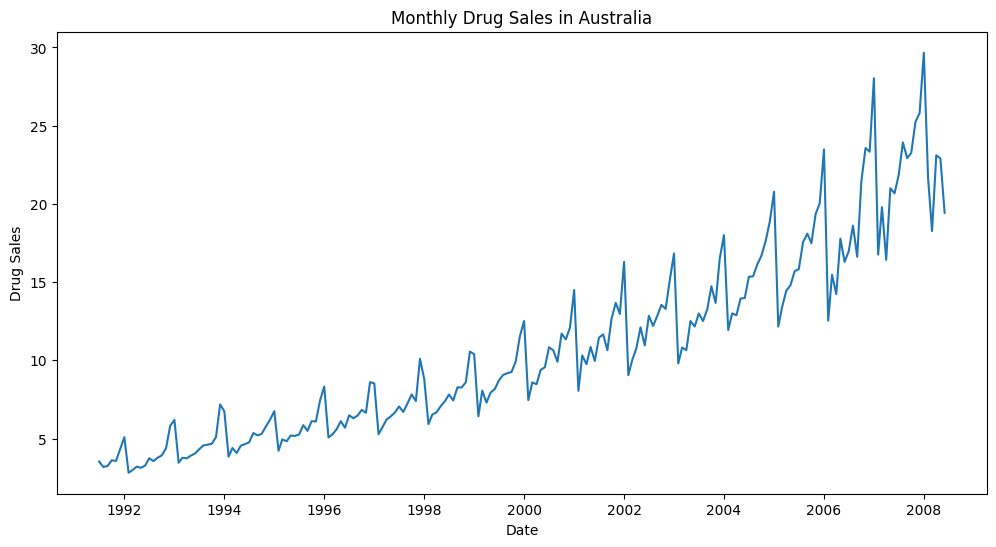

In [4]:
# 시계열 데이터 시각화하기
plt.figure(figsize=(12,6))
plt.plot(df.index, df.value)
plt.xlabel('Date')
plt.ylabel('Drug Sales')
plt.title('Monthly Drug Sales in Australia')
plt.show()

In [5]:
# 시계열 데이터의 정상성 검정하기 (ADF 검정)
result = sm.tsa.adfuller(df.value)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))

ADF Statistic: 3.145186
p-value: 1.000000
Critical Values:
	1%: -3.466
	5%: -2.877
	10%: -2.575


In [6]:
# 비정상적인 시계열을 차분하여 정상화하기 (d=1)
df_diff = df.diff().dropna()

# 차분된 시계열의 처음 5개 행 확인
print(df_diff.head())

               value
date                
1991-08-01 -0.345700
1991-09-01  0.071330
1991-10-01  0.358782
1991-11-01 -0.045134
1991-12-01  0.740502


In [7]:
# 차분된 시계열의 정상성 검정하기 (ADF 검정)
result = sm.tsa.adfuller(df_diff.value)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))

ADF Statistic: -2.495172
p-value: 0.116653
Critical Values:
	1%: -3.466
	5%: -2.877
	10%: -2.575


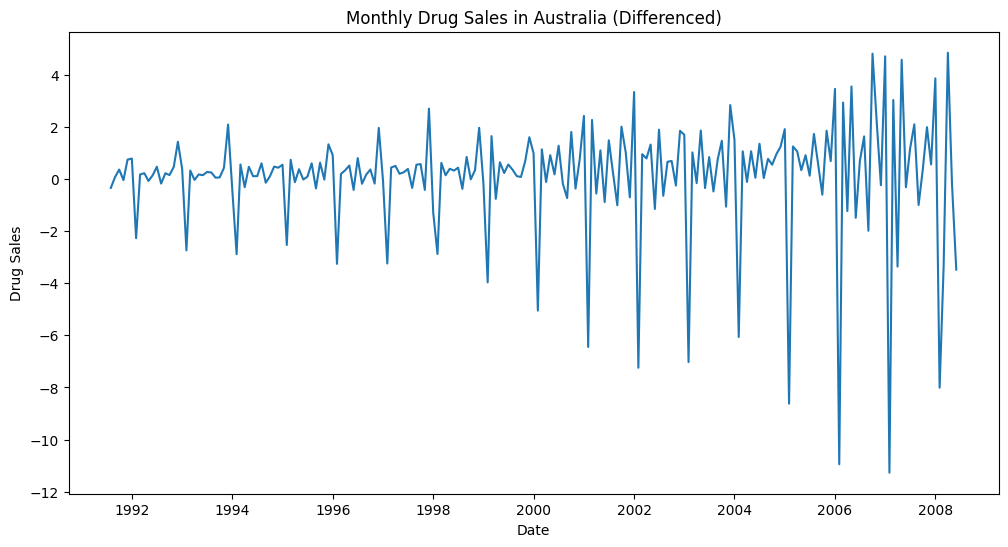

In [8]:
# 차분된 시계열을 시각화하기
plt.figure(figsize=(12,6))
plt.plot(df_diff.index, df_diff.value)
plt.xlabel('Date')
plt.ylabel('Drug Sales')
plt.title('Monthly Drug Sales in Australia (Differenced)')
plt.show()

c:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


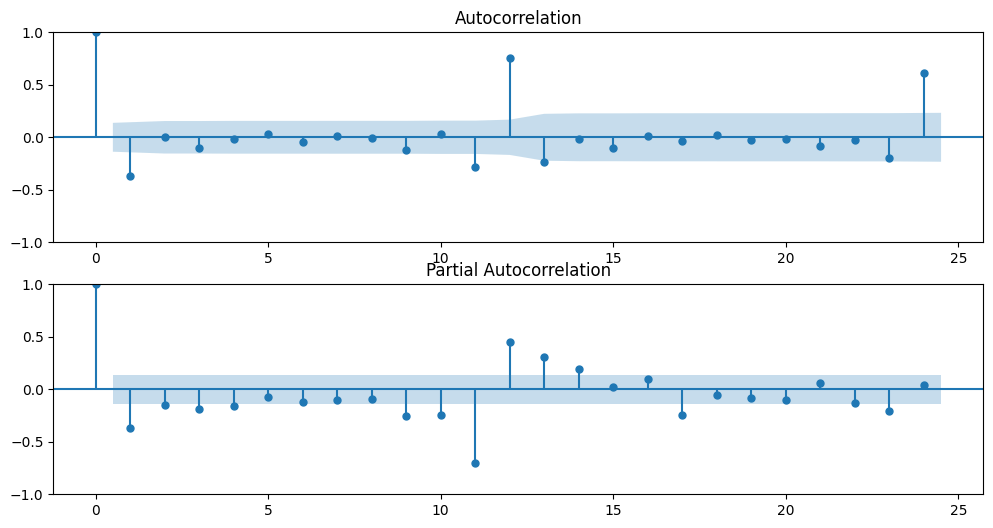

In [9]:
# 차분된 시계열에 적합한 모형을 선택하기 (ACF와 PACF 그리기)
fig, ax = plt.subplots(2, figsize=(12,6))
sm.graphics.tsa.plot_acf(df_diff.value, lags=24, ax=ax[0])
sm.graphics.tsa.plot_pacf(df_diff.value, lags=24, ax=ax[1])
plt.show()

In [11]:
# ARIMA(2,d,q) 모형의 파라미터를 추정하기 (AIC와 BIC 사용하기)
import itertools
p = q = range(0, 5)
d = 1 # 차분 횟수
pdq = list(itertools.product(p, [d], q)) # 모든 가능한 p,d,q 조합 생성



In [12]:
# 각 조합에 대해 AIC와 BIC 계산하기
results = []
for param in pdq:
    try:
        model = sm.tsa.ARIMA(df.value, order=param) # 모형 생성
        result = model.fit() # 모형 적합
        results.append((param, result.aic, result.bic)) # 결과 저장
    except:
        continue

c:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\user\AppData\Local\Programs\Python\Python310\lib\si

In [13]:
# AIC와 BIC가 가장 작은 조합 찾기
best_aic = sorted(results, key=lambda x: x[1])[0]
best_bic = sorted(results, key=lambda x: x[2])[0]
print('Best AIC: {}'.format(best_aic))
print('Best BIC: {}'.format(best_bic))

Best AIC: ((3, 1, 4), 810.4498548530316, 836.9555026853659)
Best BIC: ((3, 1, 4), 810.4498548530316, 836.9555026853659)


In [31]:
# ARIMA(2,d,q) 모형의 적합도를 평가하기 (잔차 분석과 Ljung-Box 검정 수행하기)
model = sm.tsa.ARIMA(df.value, order=(2,d,q)) # ARIMA(2,d,q) 모형 생성
result = model.fit(simple_differencing=True) # 모형 적합

ValueError: Invalid MA order. Appears to be a boolean list (since it contains a 0 element and/or multiple elements) but also contains elements greater than 1 like a list of lag orders.

: 

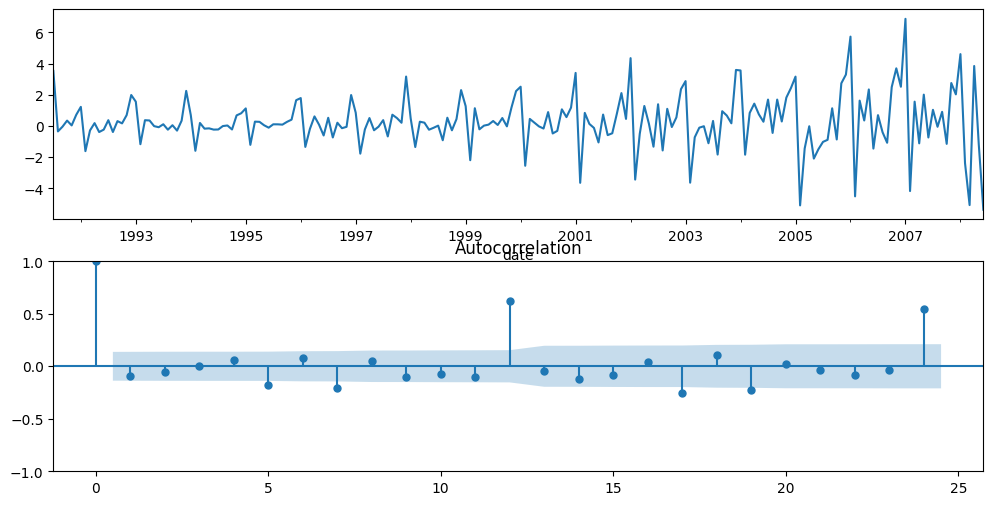

In [15]:
# 잔차 분석하기
resid = result.resid # 잔차 구하기
fig, ax = plt.subplots(2, figsize=(12,6))
resid.plot(ax=ax[0]) # 잔차 시각화하기
sm.graphics.tsa.plot_acf(resid.values.squeeze(), lags=24,
ax=ax[1]) # 잔차의 자기상관함수 그리기
plt.show()

In [16]:
# Ljung-Box 검정 수행하기 
sm.stats.acorr_ljungbox(resid.values.squeeze(), lags=[24], return_df=True)

,lb_stat,lb_pvalue
24,217.885821,3.471101e-33


In [17]:
# ARIMA(2,d,q) 모형으로 미래 값을 예측하기 (예측 구간과 신뢰 구간 구하기)
pred = result.get_prediction(start='2008-01-01', end='2009-12-01') # 예측 범위 설정
pred_ci = pred.conf_int() # 예측 구간 구하기
pred_mean = pred.predicted_mean # 예측 평균값 구하기

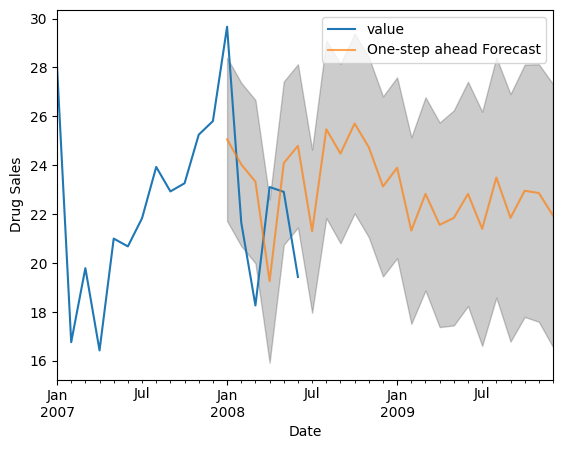

In [18]:
# 실제 값과 예측 값 비교하기
ax = df['2007':].plot(label='observed')
pred_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7)
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Drug Sales')
plt.legend()
plt.show()

In [19]:
# 예측 오차 산출하기 (RMSE 계산하기)
from sklearn.metrics import mean_squared_error
from math import sqrt

In [20]:
# 실제 값과 예측 값 추출하기
y_true = df['2008-01-01':].value # 실제 값
y_pred = pred_mean # 예측 값

In [21]:
# RMSE 계산하기
rmse = sqrt(mean_squared_error(y_true, y_pred))
print('RMSE: {:.3f}'.format(rmse))

ValueError: Found input variables with inconsistent numbers of samples: [6, 24]

In [22]:
# 예측 값 출력하기
print(pred_mean)

2008-01-01    25.060028
2008-02-01    24.032958
2008-03-01    23.329218
2008-04-01    19.262677
2008-05-01    24.086108
2008-06-01    24.793843
2008-07-01    21.301488
2008-08-01    25.472117
2008-09-01    24.477374
2008-10-01    25.707265
2008-11-01    24.736651
2008-12-01    23.132624
2009-01-01    23.897842
2009-02-01    21.326558
2009-03-01    22.829773
2009-04-01    21.563505
2009-05-01    21.846315
2009-06-01    22.827424
2009-07-01    21.400711
2009-08-01    23.496810
2009-09-01    21.848671
2009-10-01    22.957213
2009-11-01    22.863437
2009-12-01    21.942358
Freq: MS, Name: predicted_mean, dtype: float64
